In [16]:
# coding=utf-8
import sys
sys.path.append('..')

import os
import io
import random
import copy 
import re
import html

from time import time 
from multiprocessing import Pool
from collections import Counter

from functools import partial

from tqdm import tqdm_notebook
import pythainlp
from pythainlp.util import *
from pythainlp.tokenize import word_tokenize
from pythainlp.ulmfit import *

# subword-nmt
from subword_nmt import learn_bpe as learner
from subword_nmt import apply_bpe as subword_tokenizer

import fairseq 
from datetime import timedelta
from tqdm import tqdm, tqdm_notebook
from pythainlp.tokenize import DEFAULT_DICT_TRIE

from pythainlp.corpus import thai_words

import matplotlib.pyplot as plt
import seaborn as sns

print(pythainlp.__version__)
assert pythainlp.__version__ == '2.1'



2.1


In [2]:
# install BPEmb (BPE embeddings)

!pip install --q bpemb

You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from bpemb import BPEmb

bpemb_pretrained ={
    'th': {
        '25000': BPEmb(lang="th", vs=25000)
    },
    'en': {
        '25000': BPEmb(lang="en", vs=25000)
    }
}


In [4]:
with open('../data/opensubtitles/OpenSubtitles.en-th.en','r', encoding='utf-8') as f:
    en = f.read().split('\n')
len(en),en[:3]


(3281534,
 ['Slave in the Magic Mirror, come from the farthest space.',
  'Through wind and darkness, I summon thee.',
  'Speak!'])

In [5]:
with open('../data/opensubtitles/OpenSubtitles.en-th.th','r', encoding='utf-8') as f:
    th = f.read().split('\n')
    
len(th),th[:3]

(3281534,
 ['ทาสในกระจกวิเศษ, มาจากพื้นที่ที่ไกลที่สุด',
  'ผ่านลมและความมืดฉันเรียกเจ้า',
  'พูด!'])

In [6]:
# preprocess text

LIST_OF_UNKNOWN_TOKENS = [b'\x98\xc2', b'\xae\xc2', b'\x99\xc2', b'\xb1\xc2' , b'\xc2\xb7', b'\xc3\x83']
LISY_OF_TOKENS_TO_REPLACE = ['', '', '​', '', '', '', '', '', 'โ', '​',
                   '♪', '{\ cHFFFFFF }', '§', 'font color = "# 808080 "']
def unescape_string(text):
    return html.unescape(text)

def sentences_filter(sentences, lang):
    indices = []
    for index, sentence in tqdm_notebook(enumerate(sentences), total=len(sentences)):
        for token in LIST_OF_UNKNOWN_TOKENS:
            if token in sentence.encode('utf-8'):
                indices.append(index)
                break
        if len(sentence) <= 1:
            indices.append(index)
            continue
        if lang == 'th' and countthai(sentence, ignore_chars='') == 0.0:
            indices.append(index)
            continue
    return indices

def clean_sentence(sentence):
    for token in LISY_OF_TOKENS_TO_REPLACE:
        sentence = sentence.replace(token, '')
        sentence = unescape_string(sentence)
        
    return sentence

In [7]:

def tokenize_worker(sentence, lang, trie):
    
    _tokenizer_newmm = partial(pythainlp.tokenize.word_tokenize, engine='newmm',
                               keep_whitespace=False,
                              custom_dict=(trie if trie != None else DEFAULT_DICT_TRIE))
    return ' '.join(_tokenizer_newmm(sentence))
  
def tokenize_handler(sentences, lang, trie=None):
    toks = []
    p = Pool(12)
    t = time()
    _tokenize_worker = partial(tokenize_worker, lang=lang, trie=trie)
    toks = p.map(_tokenize_worker, sentences)
    
    p.close()
    p.join() # call Pool.join() to wait for the worker processes to terminate.

    print('{} s'.format(time() -t))

    return toks
  

In [8]:
def write_spaced_tokens_to_file(data, folder_name, filename):
    with open('/root/mt-opus/data/{}/{}'.format(folder_name, filename),'w') as f:
        for item in data:
            f.write(item + '\n')
            
            

In [9]:
t = time()
indices_to_filter_out_th = sentences_filter(th, lang='th')
indices_to_filter_out_en = sentences_filter(en, lang='en')

print(len(indices_to_filter_out_th))
print(len(indices_to_filter_out_en))

indices_to_filter_out = indices_to_filter_out_th + indices_to_filter_out_en
indices_to_filter_out = set(indices_to_filter_out)


filtered_th = [clean_sentence(x) for i, x in enumerate(th) if i not in indices_to_filter_out]
filtered_en = [clean_sentence(x) for i, x in enumerate(en) if i not in indices_to_filter_out]

print('{} seconds'.format(time() -t))



76544
4392
110.590975522995 seconds


In [95]:
filtered_th[0]

'ทาสในกระจกวิเศษ, มาจากพื้นที่ที่ไกลที่สุด'

In [10]:
toks = {
    'th': {
        'sentencepiece': [],
        'newmm':[]
    },
    'en': {
        'sentencepiece': [],
        'newmm':[]
    }
}

## 1a Segment texts into tokens with `newmm`

In [103]:
# toks['th']['newmm'] = tokenize_handler(filtered_th[:10000], lang='th')

# toks['en']['newmm'] = tokenize_handler(filtered_en[:10000], lang='en')

In [104]:
# # test with Pyhon Trie
# t = time()
# for sent in filtered_th[:100000]:
#      toks = pythainlp.tokenize.word_tokenize(text=sent,
#                                              engine='newmm',
#                                              keep_whitespace=False,
#                                              custom_dict=pt)
        
# print('{} s'.format(time() -t))
# # toks['th']['newmm'] = tokenize_handler(filtered_th[:10000], lang='th', trie=pt)

# # toks['en']['newmm'] = tokenize_handler(filtered_en[:10000], lang='en', trie=pt)

In [11]:
# # test with Marisa Trie
# t = time()
# for sent in filtered_th[:100000]:
#      toks = pythainlp.tokenize.word_tokenize(text=sent,
#                                              engine='newmm',
#                                              keep_whitespace=False)
# print('{} s'.format(time() -t))
# # toks['th']['newmm'] = tokenize_handler(filtered_th[:10000], lang='th', trie=pt)

# # toks['en']['newmm'] = tokenize_handler(filtered_en[:10000], lang='en', trie=pt)

In [12]:
toks['th']['newmm'] = tokenize_handler(filtered_th, lang='th')
toks['en']['newmm'] = tokenize_handler(filtered_en, lang='en')


38.89829683303833 s
38.68742847442627 s


In [13]:
toks['th']['newmm'][0:10], toks['en']['newmm'][0:10]

(['ทาส ใน กระจก วิเศษ , มาจาก พื้นที่ ที่ ไกล ที่สุด',
  'ผ่าน ลม และ ความมืด ฉัน เรียก เจ้า',
  'พูด !',
  'ให้ ฉัน เห็น พระพักตร์ ของ พระองค์',
  'สิ่ง ที่ เจ้า จะ รู้ ว่า สมเด็จ พระราชินี ของ ฉัน ได้ อย่างไร',
  'กระจก วิเศษ บน ผนัง ผู้ ที่ เป็น สังขาร หนึ่ง ทั้งหมด หรือไม่',
  'ที่ มีชื่อเสียง เป็น ความงาม ของ เจ้า พระ บาท สมเด็จ พระเจ้าอยู่หัว',
  'แต่ ถือเป็น แม่บ้าน ที่ น่ารัก ที่ ฉัน เห็น',
  'ยาจก ไม่ สามารถ ซ่อน พระคุณ อ่อนโยน ของ เธอ',
  'อนิจจา เธอ มี ความเป็นธรรม มากขึ้น กว่า เจ้า'],
 ['Slave in the Magic Mirror , come from the farthest space .',
  'Through wind and darkness , I summon thee .',
  'Speak !',
  'Let me see thy face .',
  'What wouldst thou know , my Queen ?',
  'Magic Mirror on the wall , who is the fairest one of all ?',
  'Famed is thy beauty , Majesty .',
  'But hold , a lovely maid I see .',
  'Rags cannot hide her gentle grace .',
  'Alas , she is more fair than thee .'])

__Count Word Freq for English__

In [66]:
word_freq_counter = Counter()
for sent in toks['en']['newmm']:
    words = sent.split()
#     print(words)
    for word in words:
        word_freq_counter[word] += 1


In [67]:
print('Total word types: ', len(word_freq_counter))

Total word types:  186509


In [113]:
word_freq_counter.most_common(10)

[('.', 2456581),
 (',', 1251444),
 ("'", 1248352),
 ('I', 840151),
 ('you', 695032),
 ('?', 659631),
 ('the', 564233),
 ('to', 511657),
 ('s', 454752),
 ('a', 393515)]

In [193]:
freq_counter = Counter()
for item in word_freq_counter.items():
#     print(word_freq)
    word, freq = item
#     print(word, freq)
    prev_num_freq = 0
    for num_freq in range(1,60,1):
        if freq <= num_freq and freq > prev_num_freq:
            freq_counter[num_freq] += freq
            break
        prev_num_freq = num_freq

In [194]:
freq_count_list = sorted(freq_counter.items(), key=lambda x: x[0] )

In [195]:
freq_count_list

[(1, 84041),
 (2, 46070),
 (3, 36519),
 (4, 32848),
 (5, 29645),
 (6, 27288),
 (7, 24472),
 (8, 24184),
 (9, 23175),
 (10, 22050),
 (11, 21571),
 (12, 19752),
 (13, 19435),
 (14, 19040),
 (15, 17730),
 (16, 17840),
 (17, 17697),
 (18, 15624),
 (19, 15561),
 (20, 15200),
 (21, 15876),
 (22, 15092),
 (23, 14950),
 (24, 14904),
 (25, 12725),
 (26, 14170),
 (27, 13419),
 (28, 12740),
 (29, 12760),
 (30, 12870),
 (31, 12617),
 (32, 13408),
 (33, 12342),
 (34, 11390),
 (35, 11025),
 (36, 10692),
 (37, 10249),
 (38, 11704),
 (39, 9984),
 (40, 10720),
 (41, 10414),
 (42, 10080),
 (43, 9976),
 (44, 9812),
 (45, 9900),
 (46, 9522),
 (47, 9306),
 (48, 10176),
 (49, 10633),
 (50, 8600),
 (51, 9639),
 (52, 7436),
 (53, 8533),
 (54, 9504),
 (55, 8415),
 (56, 7560),
 (57, 8550),
 (58, 8178),
 (59, 8555)]

In [196]:
x = [x[0] for x in freq_count_list]
y = [x[1] for x in freq_count_list]

print(y)


[84041, 46070, 36519, 32848, 29645, 27288, 24472, 24184, 23175, 22050, 21571, 19752, 19435, 19040, 17730, 17840, 17697, 15624, 15561, 15200, 15876, 15092, 14950, 14904, 12725, 14170, 13419, 12740, 12760, 12870, 12617, 13408, 12342, 11390, 11025, 10692, 10249, 11704, 9984, 10720, 10414, 10080, 9976, 9812, 9900, 9522, 9306, 10176, 10633, 8600, 9639, 7436, 8533, 9504, 8415, 7560, 8550, 8178, 8555]


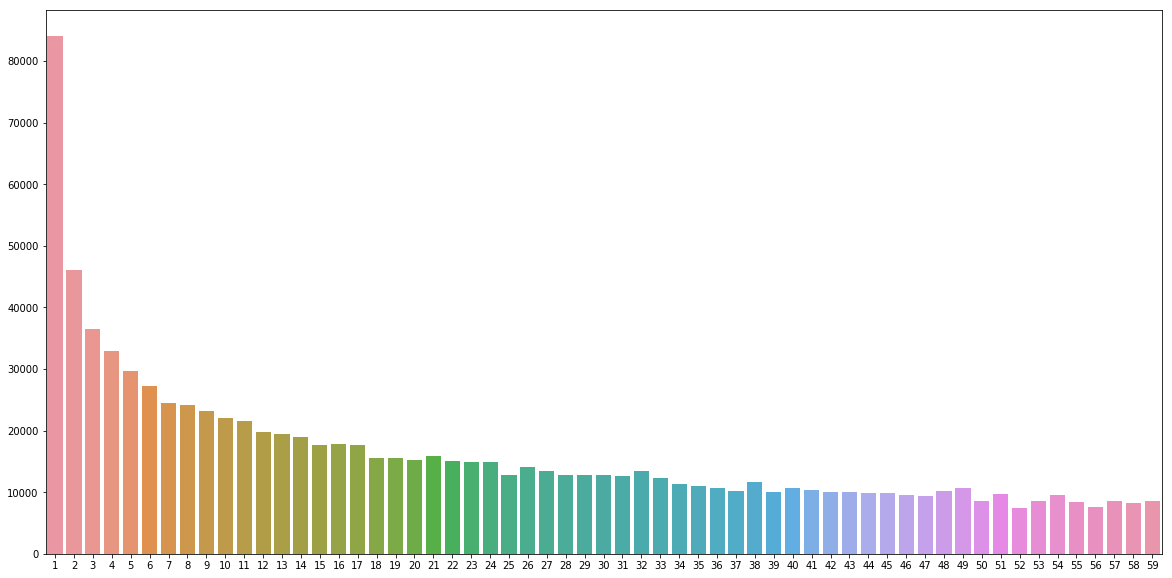

In [197]:
plt.figure(figsize=(20,10))

sns.barplot(x=x, y=y)

English word with frequency = 1

In [198]:
def print_words(freq=1):
    word_list = []
    for item in word_freq_counter.items():
        word, _freq = item
        if _freq == freq:
            word_list.append(word)
    return word_list

In [202]:
print('number of tokens that has word freq=1 :', len(print_words()))
print_words()

number of tokens that has word freq=1 : 84041


['tenderl',
 'Rejoi',
 'raindro',
 'heerfully',
 'swee',
 '-Shine',
 'dig-a-dig',
 'heigh',
 'goldenrod',
 '-Sounded',
 '-Break',
 '-Chop',
 '-Gee',
 'a-doin',
 'Quincess',
 'spoodledug',
 'dapple',
 'lumpkins',
 'Lumple',
 'dapplins',
 'Crapple',
 'dumpkins',
 'Gooseberry',
 '-Hah',
 'Ste',
 'disgra',
 'ull',
 'soa',
 'sli',
 'perfoom',
 'ute',
 '-Supper',
 'jewelled',
 'raiment',
 'hased',
 'Disgustin',
 'menfolks',
 '-Onl',
 '-Thrilling',
 '-Kee',
 'Notre-Dame',
 'Defective',
 'Dispatches',
 'Pari-Mutual',
 'Hynkelstrasse',
 'Thinker',
 'Kibitzen',
 'Dissenting',
 'stenographers',
 'Doucement',
 'effete',
 'double-dyed',
 'Langobardians',
 'Hynk',
 'ex-Commander',
 'Meyerberg',
 '2,975,000',
 'massed',
 'mix-up-a',
 'No-a',
 'meet-a',
 'big-a',
 'feel-a',
 'a-growing',
 'find-a',
 'can-a',
 'll-Dig-a-Ditchy',
 'up-a',
 'triste',
 'talk-a',
 'Formalities',
 'hot-a',
 'remove-a',
 'not-a',
 'want-a',
 'have-a',
 'yodeler',
 'machine-guns',
 'veniet',
 'delectis',
 'non-Aryans',
 'goos

## 1b Segment texts into BPE tokens with SentencePiece (BPEmb)


In [108]:
def encode_bpe(sentences, lang, n_vocab=25000):
    """Return a list of bpe tokens give a list of sentences"""
    segmented_sentences = []
    for sentence in tqdm_notebook(sentences, total=len(sentences)):
#         print(sentence)
        bpe_tokens = bpemb_pretrained[lang]['{}'.format(n_vocab)].encode(sentence)
        segmented_sentences.append(' '.join(bpe_tokens))
        
    return segmented_sentences

### 1.1 Thai language

In [109]:
toks['th']['sentencepiece'] = encode_bpe(filtered_th, 'th', 25000)

print(toks['th']['sentencepiece'][0:10])


['▁ท าส ใน กระจก วิเศษ , ▁มาจาก พื้นที่ ที่ ไกล ที่สุด', '▁ผ่าน ลม และความ มืด ฉัน เรียก เจ้า', '▁พูด !', '▁ให้ ฉัน เห็น พระพักตร์ ของ ▁พระองค์', '▁สิ่งที่ เจ้า จะ รู้ว่า สมเด็จพระราชินี ▁ของ ฉัน ได้อย่างไร', '▁กระจ ก วิเศษ บน ผนัง ▁ผู้ ที่เป็น สัง ขาร หนึ่ง ทั้งหมด ▁หรือไม่', '▁ที่มีชื่อเสียง เป็น ความงาม ของ ▁เจ้า พระบาทสมเด็จพระ เจ้าอยู่หัว', '▁แต่ ถือเป็น แม่ บ้าน ที่น ่ารัก ที่ ฉัน ▁เห็น', '▁ยา จก ไม่สามารถ ซ่อน พระคุณ ▁อ่อน โยน ของเธอ', '▁อน ิจ จา เธอ มีความเป็น ธรรม ▁มาก ขึ้น กว่า เจ้า']


### 1.2 English language

In [110]:
toks['en']['sentencepiece']  = encode_bpe(filtered_en, 'en', 25000)
print(toks['en']['sentencepiece'][0:10])


['▁slave ▁in ▁the ▁magic ▁mirror , ▁come ▁from ▁the ▁fart hest ▁space .', '▁through ▁wind ▁and ▁darkness , ▁i ▁summon ▁the e .', '▁speak !', '▁let ▁me ▁see ▁thy ▁face .', '▁what ▁would st ▁thou ▁know , ▁my ▁queen ?', '▁magic ▁mirror ▁on ▁the ▁wall , ▁who ▁is ▁the ▁fa ire st ▁one ▁of ▁all ?', '▁famed ▁is ▁thy ▁beauty , ▁majesty .', '▁but ▁hold , ▁a ▁lov ely ▁maid ▁i ▁see .', '▁ra gs ▁cannot ▁hide ▁her ▁gentle ▁grace .', '▁al as , ▁she ▁is ▁more ▁fair ▁than ▁the e .']


## 2. Split train-valid-test 

In [111]:
#train-valid-test split 80/10/10

n = len(toks['th']['newmm'])

print('N = ',n)
idx = list(range(n))

random.seed(1234) # Set SEED
random.shuffle(idx)

train_idx, valid_idx, test_idx = idx[:int(n*0.8)], idx[int(n*0.8):int(n*0.9)], idx[int(n*0.9):]

dataset_split = {}
dataset_split['train'] = train_idx
dataset_split['valid'] = valid_idx
dataset_split['test'] = test_idx


len(train_idx),len(valid_idx),len(test_idx)



N =  3202751


(2562200, 320275, 320276)

In [112]:
dataset = {
    'train': {
        'en': {
            'sentencepiece': [],
            'newmm':[]
        },
        'th': {
             'sentencepiece': [],
            'newmm':[]
        }
    },
    'valid': {
        'en': {
            'sentencepiece': [],
            'newmm':[]
        },
        'th': {
             'sentencepiece': [],
            'newmm':[]
        }
    },
    'test': {
        'en': {
            'sentencepiece': [],
            'newmm':[]
        },
        'th': {
             'sentencepiece': [],
            'newmm':[]
        }
    }
}

for split_name in ['train', 'valid', 'test']:
    for lang in ['th', 'en']:
        for tok_type in ['sentencepiece', 'newmm']:

            dataset[split_name][lang][tok_type] = [toks[lang][tok_type][i] for i in dataset_split[split_name]] 


In [113]:
print(dataset['train']['th']['newmm'][0:2],'\n')
print(dataset['train']['en']['newmm'][0:2],'\n')
print(dataset['train']['th']['sentencepiece'][0:2],'\n')
print(dataset['train']['en']['sentencepiece'][0:2],'\n')

['เบค กี้ เธอ ทำท่า แปลก ๆ เมื่อกี้ ใน ห้อง', 'อยู่ กับ เธอ แอน นา จะ นำทาง คุณ ผม จะ กลับ ไป'] 

['Becky , um , you were acting particularly strange in there just now .', "Stay with her so Anna can guide you . I ' m going back ."] 

['▁เบ ค กี้ ▁เธอ ทํา ท่า แปลก ๆ ▁เมื่อ กี้ ▁ในห้อง', '▁ อยู่กับ เธอ ▁แอนนา จะนํา ทาง คุณ ▁ผม จะ กลับไป'] 

['▁bec ky , ▁um , ▁you ▁were ▁acting ▁particularly ▁strange ▁in ▁there ▁just ▁now .', "▁stay ▁with ▁her ▁so ▁anna ▁can ▁guide ▁you . ▁i ' m ▁going ▁back ."] 



In [119]:
# Counting number of tokens for train, valid, test
counter = Counter( )
for dataset_type in ['train', 'valid', 'test']:
    for th_sent_toks in dataset[dataset_type]['th']['newmm']:
        counter['th_{}_n_toks'.format(dataset_type)] += len(th_sent_toks)
    for en_sent_toks in dataset[dataset_type]['en']['newmm']:
        counter['en_{}_n_toks'.format(dataset_type)] += len(en_sent_toks)

print(counter) 

Counter({'en_train_n_toks': 92383739, 'th_train_n_toks': 86683223, 'en_valid_n_toks': 11536351, 'en_test_n_toks': 11535798, 'th_test_n_toks': 10833242, 'th_valid_n_toks': 10826042})


In [124]:

for tok_type_src in ['sentencepiece', 'newmm']:
    for tok_type_tgt in ['sentencepiece', 'newmm']:
        langs = ['th', 'en']
        for lang in langs:
            src_lang = lang
            tgt_lang = 'en' if lang =='th' else 'th'
            FOLDER_NAME = "opensubtitles_tok/{}-{}/{}-{}".format(tok_type_src, tok_type_tgt, src_lang, tgt_lang )
            FOLDER_NAME_BIN = "opensubtitles_bin/{}-{}/{}-{}".format(tok_type_src, tok_type_tgt, src_lang, tgt_lang)
           
            
            # Create directories
            print('create directories: ')
            print('dir: ../data/{}'.format(FOLDER_NAME))
            print('dir: ../data/{}'.format(FOLDER_NAME_BIN))

            !mkdir -p ../data/{FOLDER_NAME}
            !mkdir -p ../data/{FOLDER_NAME_BIN}

            for split_name in ['train', 'valid', 'test']:
                
                write_spaced_tokens_to_file(dataset[split_name][src_lang][tok_type_src],
                                            FOLDER_NAME, '{}.{}'.format(split_name, src_lang))
                
                write_spaced_tokens_to_file(dataset[split_name][tgt_lang][tok_type_tgt],
                                            FOLDER_NAME, '{}.{}'.format(split_name, tgt_lang))


create directories: 
dir: ../data/opensubtitles_tok/sentencepiece-sentencepiece/th-en
dir: ../data/opensubtitles_bin/sentencepiece-sentencepiece/th-en
create directories: 
dir: ../data/opensubtitles_tok/sentencepiece-sentencepiece/en-th
dir: ../data/opensubtitles_bin/sentencepiece-sentencepiece/en-th
create directories: 
dir: ../data/opensubtitles_tok/sentencepiece-newmm/th-en
dir: ../data/opensubtitles_bin/sentencepiece-newmm/th-en
create directories: 
dir: ../data/opensubtitles_tok/sentencepiece-newmm/en-th
dir: ../data/opensubtitles_bin/sentencepiece-newmm/en-th
create directories: 
dir: ../data/opensubtitles_tok/newmm-sentencepiece/th-en
dir: ../data/opensubtitles_bin/newmm-sentencepiece/th-en
create directories: 
dir: ../data/opensubtitles_tok/newmm-sentencepiece/en-th
dir: ../data/opensubtitles_bin/newmm-sentencepiece/en-th
create directories: 
dir: ../data/opensubtitles_tok/newmm-newmm/th-en
dir: ../data/opensubtitles_bin/newmm-newmm/th-en
create directories: 
dir: ../data/opens

In [125]:
!head ../data/opensubtitles_tok/newmm-sentencepiece/th-en/train.en


▁bec ky , ▁um , ▁you ▁were ▁acting ▁particularly ▁strange ▁in ▁there ▁just ▁now .
▁stay ▁with ▁her ▁so ▁anna ▁can ▁guide ▁you . ▁i ' m ▁going ▁back .
▁look .
▁oh , ▁no , ▁it ' s ▁the ▁other ▁way ▁around , ▁dr . ▁lewis .
▁sort ▁of .
▁bart ender , ▁something ▁really ▁strong , ▁please .
▁yes , ▁obviously .
▁la ' s ▁so ▁nice .
▁i ' m ▁going ▁to ▁fix ▁it .
▁i ▁get ▁b ored .


In [126]:
!head ../data/opensubtitles_tok/newmm-sentencepiece/th-en/train.th

เบค กี้ เธอ ทำท่า แปลก ๆ เมื่อกี้ ใน ห้อง
อยู่ กับ เธอ แอน นา จะ นำทาง คุณ ผม จะ กลับ ไป
ฟัง นะ
พอดี เลย ดร. ลี วิ ส
แบบ ว่า
เอ่อ บาร์ เท็น เด อร ์ ขอ อะไร ที่
ก็ ใช่ ห น่ะ สิ
แอลเอ สวย เนอะ
ฉัน กำลังจะ แก้ ไขมัน
ฉัน เบื่อ ละ
